In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import argparse

d:\ForensicSex\.venv\Lib\site-packages\torch\nn\modules\module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class index: 0


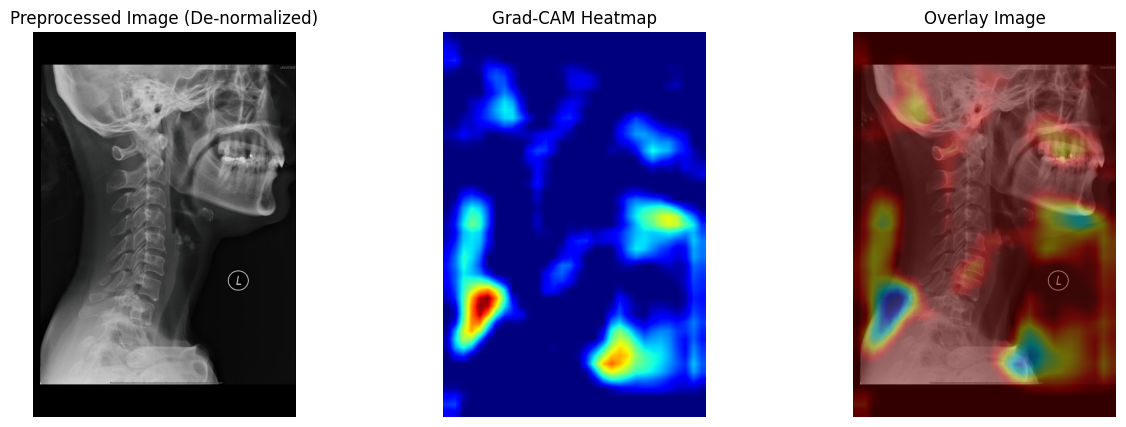

Overlay image saved to D:\ForensicSex\grad-cam\example.jpg


In [ ]:
class GradCAM:
    """
    Implements Grad-CAM for a given PyTorch model and a target convolutional layer.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.register_hooks()
    
    def register_hooks(self):
        def forward_hook(module, input, output):
            # Save the output feature map from the target layer
            self.activations = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            # Save the gradients computed in this layer during backpropagation
            self.gradients = grad_out[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def generate(self, input_tensor, target_class=None):
        """
        Generates the Grad-CAM heatmap for an input tensor.
        
        Args:
            input_tensor (torch.Tensor): Preprocessed input image tensor of shape (1, C, H, W).
            target_class (int, optional): Class index for Grad-CAM. If None, the model's top predicted class is used.
            
        Returns:
            grad_cam_map (np.array): The computed Grad-CAM heatmap (2D numpy array, values in [0, 1]).
            target_class (int): Class index used for computing Grad-CAM.
            output (torch.Tensor): The model output.
        """
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_tensor)  # (1, num_classes)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Compute the loss for the target class
        loss = output[0, target_class]
        loss.backward()
        
        # Global average pooling of the gradients in the target layer
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Weighted combination of the activation maps
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        
        # Upsample the CAM to the input image size
        grad_cam_map = F.interpolate(grad_cam_map, size=(input_tensor.size(2), input_tensor.size(3)),
                                     mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze(0).squeeze(0)
        
        # Normalize the heatmap to [0, 1]
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max() + 1e-8
        
        return grad_cam_map.cpu().numpy(), target_class, output

def preprocess_image(image_path):
    """
    Preprocess the input image using the same transformation as for training/validation.
    """
    transform_pipeline = transforms.Compose([
        transforms.CenterCrop((1500, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    tensor_image = transform_pipeline(image)
    return tensor_image.unsqueeze(0)  # add batch dimension

def deprocess_image(tensor_image):
    """
    Reverse the normalization on the preprocessed image so it can be visualized.
    
    Args:
        tensor_image (torch.Tensor): Preprocessed image tensor of shape (1, C, H, W).
    
    Returns:
        image (np.array): De-normalized image as a uint8 numpy array (H, W, C) in RGB.
    """
    # Define the mean and std (must match those used in preprocess_image)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Squeeze the batch dimension then de-normalize
    image = tensor_image.clone().cpu().squeeze(0)  
    image = image * std + mean  
    image = image.clamp(0, 1)
    image = image.permute(1, 2, 0).numpy()  # (H, W, C)
    image = np.uint8(255 * image)
    return image

def overlay_heatmap_on_image(image_array, heatmap, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on an image provided as a numpy array.
    
    Args:
        image_array (np.array): The RGB image array (H, W, C).
        heatmap (np.array): 2D Grad-CAM heatmap with values in [0, 1].
        alpha (float): The opacity factor for the heatmap overlay.
        
    Returns:
        overlay (np.array): The image with the heatmap overlay.
    """
    # Resize the heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image_array.shape[1], image_array.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Overlay the heatmap on the image
    overlay = cv2.addWeighted(image_array, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def main():
    parser = argparse.ArgumentParser(description="Grad-CAM for PyTorch-based sex estimation")    

    parser.add_argument('--model_path', type=str, default=r'xxx', help='Path to the trained PyTorch model')
    parser.add_argument('--image_path', type=str, default=r'xxx', help='Path to the input radiograph image')
    parser.add_argument('--output_path', type=str, default=r'D:\ForensicSex\grad-cam\example.jpg', help='Path to save the Grad-CAM overlay image')
    
    # Use parse_known_args to ignore any extra arguments (such as those injected by Jupyter)
    args, _ = parser.parse_known_args()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the trained model (ensure it's saved as a full model)
    model = torch.load(args.model_path, map_location=device,weights_only=False)
    model.eval()
    
    # Select the target layer for Grad-CAM (ResNet-18: conv2 in the last block of layer4)
    target_layer = model.layer4[-1].conv2
    
    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)
    
    # ---- Step 1: Preprocess the original image ----
    input_tensor = preprocess_image(args.image_path).to(device)
    
    # ---- Step 2: Generate Grad-CAM for the preprocessed image ----
    cam, predicted_class, output = grad_cam.generate(input_tensor)
    print("Predicted class index:", predicted_class)
    
    # ---- Step 3: Overlay heatmap on the preprocessed image ----
    # First, deprocess the image so it is in displayable (RGB) format
    preproc_img = deprocess_image(input_tensor)
    # Overlay the heatmap on this deprocessed image
    overlay_img = overlay_heatmap_on_image(preproc_img, cam, alpha=0.4)
    
    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Preprocessed Image (De-normalized)")
    plt.imshow(preproc_img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cam, cmap='jet')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Image")
    plt.imshow(overlay_img)
    plt.axis('off')
    
    plt.show()
    
    # Save the overlay image
    overlay_bgr = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(args.output_path, overlay_bgr)
    print(f"Overlay image saved to {args.output_path}")

if __name__ == '__main__':
    main()